In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
import os
from torchvision import transforms, datasets
import torch
from group_conv import Rot90Group, bilinear_interpolation, GroupEquivariantCNN, CNN
import matplotlib.pyplot as plt
from utils import *
import torch.optim as optim
import torch.nn as nn
from train import Trainer, PlTrainer
import pytorch_lightning as pl 
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import numpy as np




In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

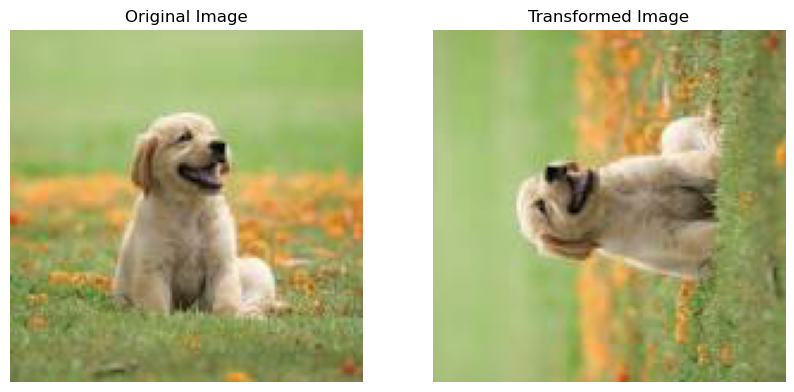

In [4]:
test_rotation_group()

In [47]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


Image shape: torch.Size([1, 28, 28]), Label: 9


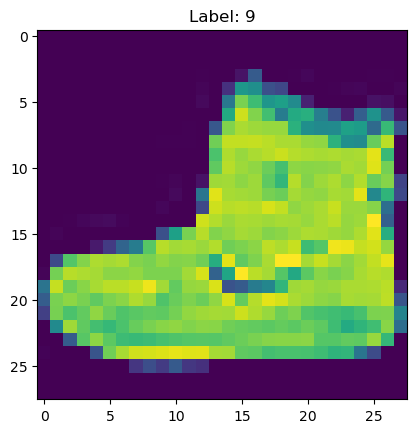

Image shape: torch.Size([1, 28, 28]), Label: 0


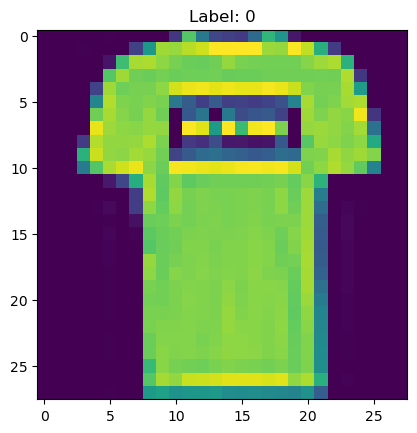

Image shape: torch.Size([1, 28, 28]), Label: 0


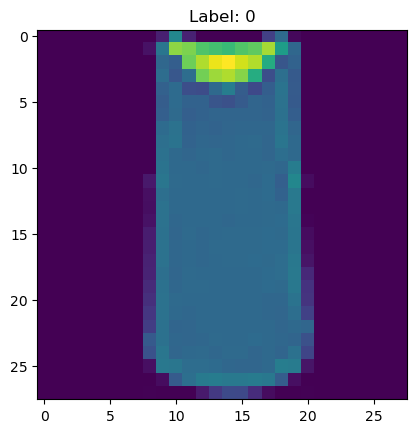

In [48]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize((0.1307,), (0.3081,))
                                                  ])

# To demonstrate the generalization capabilities our rotation equivariant layers bring, we apply a random
# rotation between 0 and 360 deg to the test set.
test_transform = transforms.Compose([transforms.ToTensor(),
                                                 RandomRotationFromSet([0, 90, 180, 270]),
                                                 transforms.Normalize((0.1307,), (0.3081,))
                                                 ])
test_transform_full = transforms.Compose([transforms.ToTensor(),
                                                 transforms.RandomRotation(
                                                [0, 360]),
                                                 transforms.Normalize((0.1307,), (0.3081,))
                                                 ])
train_ds = datasets.FashionMNIST(root="data", download=True, train=True, transform=train_transform)
test_ds = datasets.FashionMNIST(root="data", download=True, train=False, transform=test_transform)
test_ds_full = datasets.FashionMNIST(root="data", download=True, train=False, transform=test_transform_full)


train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False)
test_loader_full = torch.utils.data.DataLoader(test_ds_full, batch_size=128, shuffle=False) 

for i in range(3):
    x,y = train_ds[i]
    print(f"Image shape: {x.shape}, Label: {y}")
    plt.imshow(x.squeeze().numpy())
    plt.title(f"Label: {y}")
    plt.show()

Image shape: torch.Size([1, 28, 28]), Label: 9


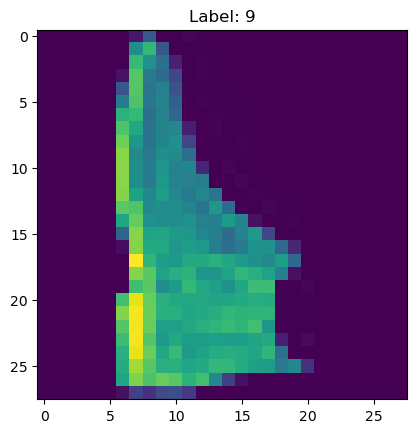

Image shape: torch.Size([1, 28, 28]), Label: 2


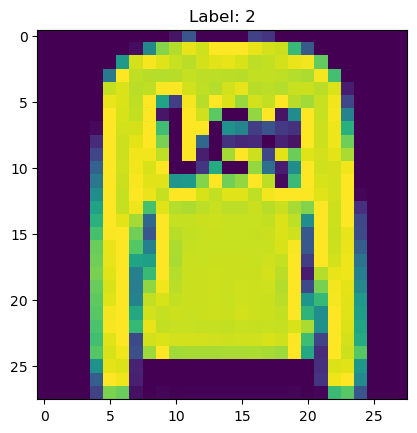

Image shape: torch.Size([1, 28, 28]), Label: 1


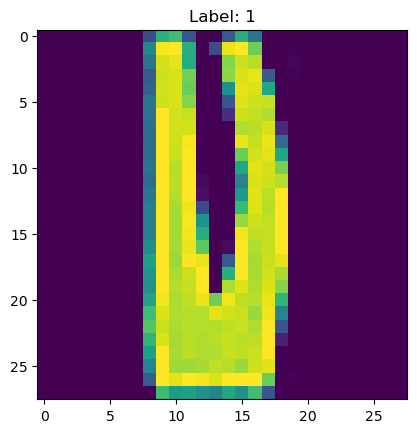

Image shape: torch.Size([1, 28, 28]), Label: 1


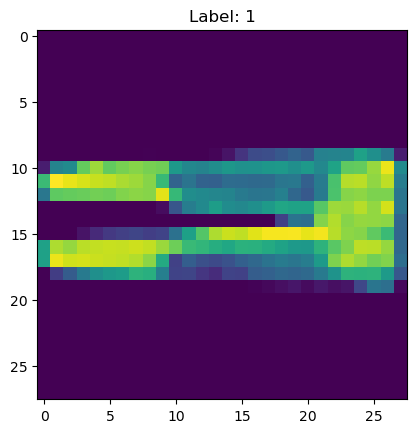

Image shape: torch.Size([1, 28, 28]), Label: 6


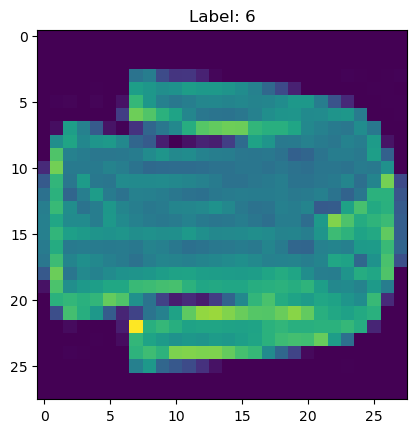

In [49]:
for i in range(5):
    x,y = test_ds[i]
    print(f"Image shape: {x.shape}, Label: {y}")
    plt.imshow(x.squeeze().numpy())
    plt.title(f"Label: {y}")
    plt.show()

In [50]:
rot_group = Rot90Group(order=4).to(device)
optim_params = {'lr':1e-2, 'weight_decay':1e-5}
cnn_params = {'in_channels':1, 'out_channels':10,
              'kernel_size':3, 'num_hidden':5, 'hidden_channels':32}
gcnn_params = {'group':rot_group, 'in_channels':1, 'out_channels':10,
              'kernel_size':3, 'num_hidden':5, 'hidden_channels':16}
loss_fn = nn.CrossEntropyLoss()
cnn = CNN(**cnn_params).to(device)
# cnn number of channels is increased to get the same number of parameters as gcnn
cnn_optimizer = optim.AdamW(cnn.parameters(), lr=1e-2, weight_decay=1e-5)
gcnn = GroupEquivariantCNN(**gcnn_params).to(device)
gcnn_optimizer = optim.AdamW(gcnn.parameters(), **optim_params)
print('cnn number of parameters', count_params(cnn))
print('gcnn number of parameters', count_params(gcnn))

cnn number of parameters 46890
gcnn number of parameters 46394


In [51]:
cnn_trainer = Trainer(model=cnn, optimizer=cnn_optimizer, criterion=loss_fn, optim_params=optim_params,
                      net_params = cnn_params, train_dataloader=train_loader,val_dataloader=test_loader, device=device, num_classes=1,
                      log_path='experiments/cnn', exp_num=0)

In [52]:
cnn_results = cnn_trainer.fit(num_epochs=10, device=device, )

Starting training for 10 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 5, 'hidden_channels': 32}


Epoch: 9, val_loss:  4.242397308349609: 100%|██████████| 79/79 [00:05<00:00, 14.85it/s] 


In [53]:
gcnn_trainer = Trainer(model=gcnn, optimizer=gcnn_optimizer, criterion=loss_fn, optim_params=optim_params,
                      net_params = gcnn_params, train_dataloader=train_loader,val_dataloader=test_loader, device=device, num_classes=1,
                      log_path='experiments/gcnn', exp_num=0)

In [54]:
gcnn_results = gcnn_trainer.fit(num_epochs=10, device=device, )

Starting training for 10 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 5, 'hidden_channels': 16}


Epoch: 9, val_loss:  0.9386085271835327: 100%|██████████| 79/79 [00:05<00:00, 15.49it/s]


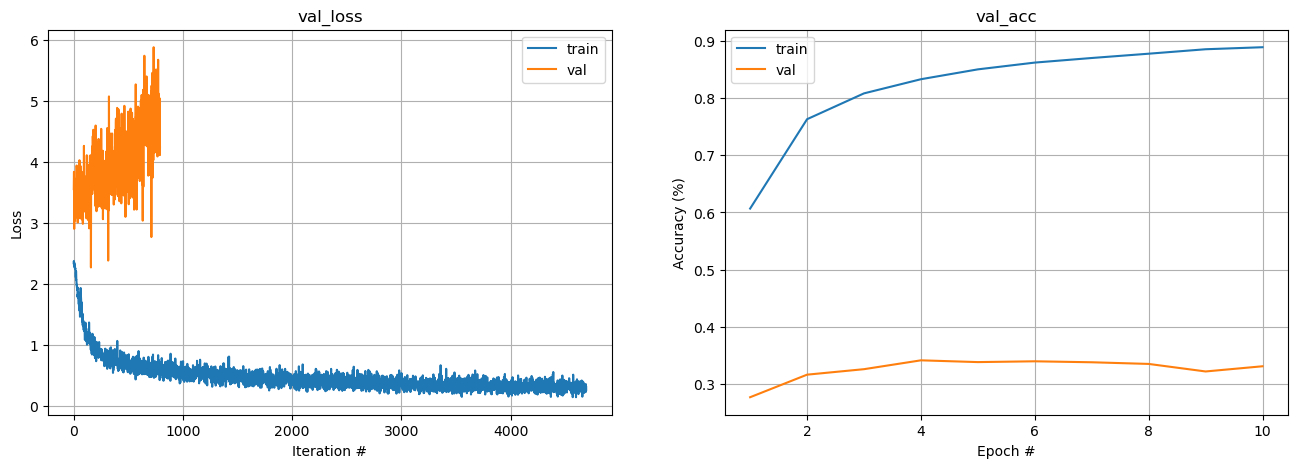

In [55]:
plot_fit(cnn_results, train_test_overlay=True)
plt.savefig('experiments/cnn/exp0/loss_acc.png')

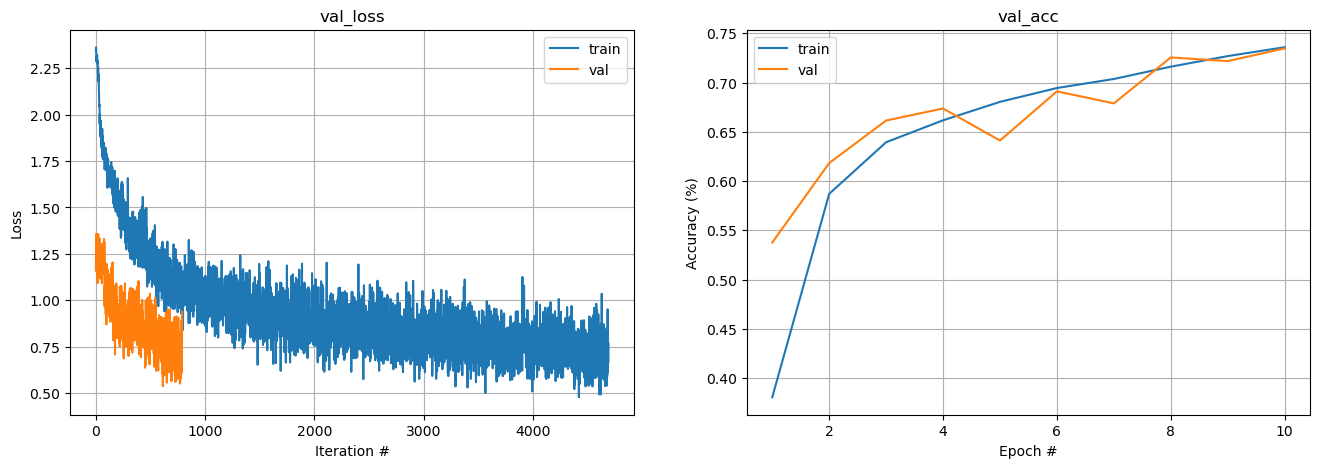

In [56]:
plot_fit(gcnn_results, train_test_overlay=True)
plt.savefig('experiments/gcnn/exp0/loss_acc.png')

In [57]:
cnn_trainer = Trainer(model=cnn, optimizer=cnn_optimizer, criterion=loss_fn, optim_params=optim_params,
                      net_params = cnn_params, train_dataloader=train_loader,val_dataloader=test_loader_full, device=device, num_classes=1,
                      log_path='experiments/cnn', exp_num=1)

In [58]:
cnn_results = cnn_trainer.fit(num_epochs=10, device=device, )

Starting training for 10 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 5, 'hidden_channels': 32}


Epoch: 9, val_loss:  4.830434322357178: 100%|██████████| 79/79 [00:07<00:00, 11.21it/s] 


In [59]:
gcnn_trainer = Trainer(model=gcnn, optimizer=gcnn_optimizer, criterion=loss_fn, optim_params=optim_params,
                      net_params = gcnn_params, train_dataloader=train_loader,val_dataloader=test_loader_full, device=device, num_classes=1,
                      log_path='experiments/gcnn', exp_num=1)

In [60]:
gcnn_results = gcnn_trainer.fit(num_epochs=10, device=device, )

Starting training for 10 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 5, 'hidden_channels': 16}


Epoch: 9, val_loss:  2.5935397148132324: 100%|██████████| 79/79 [00:07<00:00, 10.26it/s]


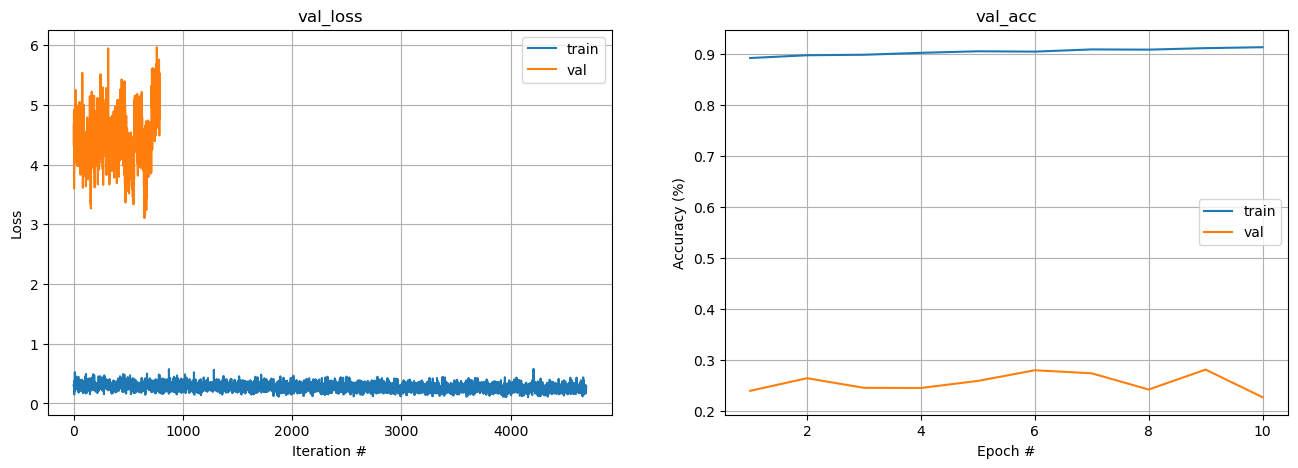

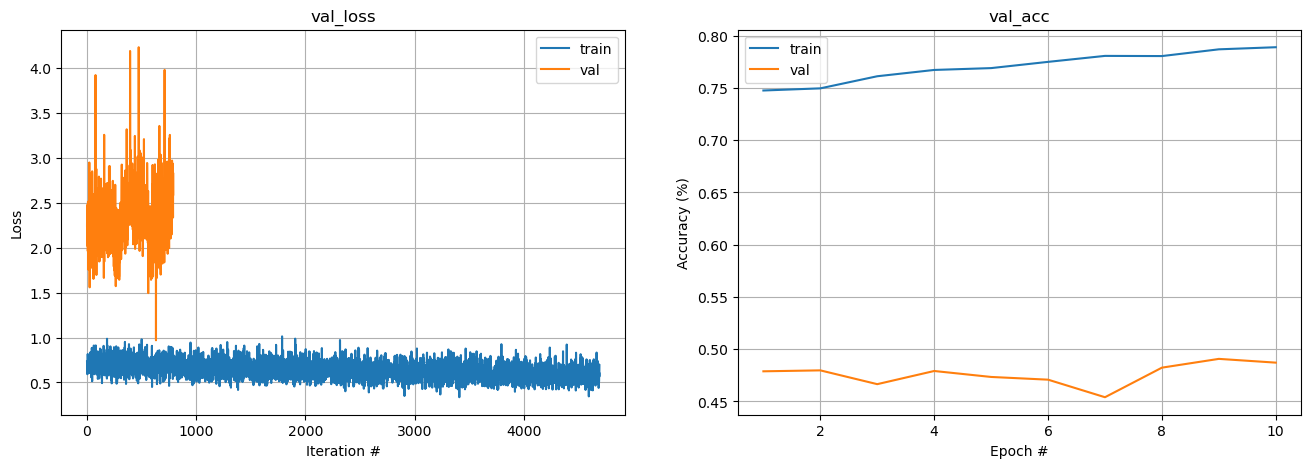

In [61]:
plot_fit(cnn_results, train_test_overlay=True)
plt.savefig('experiments/cnn/exp1/loss_acc.png')
plot_fit(gcnn_results, train_test_overlay=True)
plt.savefig('experiments/gcnn/exp1/loss_acc.png')

In [62]:
pred, target, features = cnn_trainer.predict(test_loader, device, num_iter=1)
print(pred.shape, target.shape, len(features))

6
(0, 1) torch.Size([128]) (0, 1) torch.Size([128])
target len:  128 dataset:  10000
(128, 1) (128, 1) 6


In [63]:
digit, label = train_ds[1000]
# Get a set of angles by which to rotate this image.
rots = torch.linspace(0, 360 - 360/4, 4)

# Rotate the input image and push it through the normalization transform.
rot_digit = torch.stack(tuple(transforms.functional.rotate(digit, a.item(),transforms.functional.InterpolationMode.BILINEAR) for a in rots))
rot_digit = transforms.Normalize((0.1307,), (0.3081,))(rot_digit)

# Create a subfigure for every rotated input.
fig, ax = plt.subplots(1, rots.numel(), figsize=(10,3))

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        rot_digit[idx, :, :].squeeze()
    )
    ax[idx].set_title(f"{int(rotation)} deg")

fig.text(0.5, 0.04, 'Rotations of input image', ha='center')
plt.savefig('sample.png')
plt.close()

# Forward it through the first few layers of the CNN.

rot_digit = rot_digit.to(device)
cnn_out = cnn_trainer.model.first_conv(rot_digit)
cnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(cnn_out, cnn_out.shape[-3:]))
for i in range(5):
    cnn_out = cnn_trainer.model.convs[i](cnn_out)
    cnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(cnn_out, cnn_out.shape[-3:]))

# Let's also see what happens after we apply projection over remaining spatial dimensions.
projected_cnn_out = torch.nn.functional.adaptive_avg_pool2d(cnn_out, 1).squeeze()

# Forward it through the first few layers of the GCNN.
gcnn_out = gcnn_trainer.model.lifting_conv(rot_digit)
gcnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))
for i in range(5):
    gcnn_out = gcnn_trainer.model.gconvs[i](gcnn_out)
    gcnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))

# And let's see what happens if we apply the projection on this equivariant representation.
projected_gcnn_out = torch.mean(gcnn_out, dim=(-3, -2, -1))

In [64]:
show_feature_maps(model_out=cnn_out, rots=rots, out_channel_idx=5, save_path='experiments/cnn/exp0', show_group=False)

In [65]:
show_feature_maps(model_out=gcnn_out, rots=rots, out_channel_idx=5,save_path='experiments/gcnn/exp0', show_group=True)

In [66]:
h_channels = [8,16,32,64]
n_layers = [1,2,4,8]
accs = []
x = []
y = []
loss_fn = nn.CrossEntropyLoss()
for l in n_layers:
    for h in h_channels:
        optim_params = {'lr':1e-2, 'weight_decay':1e-5}
        gcnn_params = {'group':rot_group, 'in_channels':1, 'out_channels':10,
              'kernel_size':3, 'num_hidden':l, 'hidden_channels':h}
        gcnn = GroupEquivariantCNN(**gcnn_params).to(device)
        gcnn_optimizer = optim.AdamW(gcnn.parameters(), **optim_params)
        gcnn_trainer = Trainer(model=gcnn, optimizer=gcnn_optimizer, criterion=loss_fn, optim_params=optim_params,
                      net_params = gcnn_params, train_dataloader=train_loader,val_dataloader=test_loader, device=device, num_classes=1,
                      log_path='experiments/gcnn', exp_num=1)
        gcnn_results = gcnn_trainer.fit(num_epochs=1, device=device, )
        accs.append(gcnn_results['val_acc'][-1])
        x.append(l)
        y.append(h)
print(len(x),len(y), len(accs))

        

Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 1, 'hidden_channels': 8}


Epoch: 0, val_loss:  1.6679438352584839: 100%|██████████| 79/79 [00:05<00:00, 15.14it/s]


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 1, 'hidden_channels': 16}


Epoch: 0, val_loss:  1.8009908199310303: 100%|██████████| 79/79 [00:05<00:00, 15.22it/s]


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 1, 'hidden_channels': 32}


Epoch: 0, val_loss:  1.6261261701583862: 100%|██████████| 79/79 [00:05<00:00, 14.71it/s]


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 1, 'hidden_channels': 64}


Epoch: 0, val_loss:  1.373299241065979: 100%|██████████| 79/79 [00:05<00:00, 13.30it/s] 


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 2, 'hidden_channels': 8}


Epoch: 0, val_loss:  1.6217249631881714: 100%|██████████| 79/79 [00:05<00:00, 15.04it/s]


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 2, 'hidden_channels': 16}


Epoch: 0, val_loss:  1.4499750137329102: 100%|██████████| 79/79 [00:05<00:00, 14.89it/s]


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 2, 'hidden_channels': 32}


Epoch: 0, val_loss:  1.5208218097686768: 100%|██████████| 79/79 [00:05<00:00, 14.17it/s]


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 2, 'hidden_channels': 64}


Epoch: 0, val_loss:  1.5249943733215332: 100%|██████████| 79/79 [00:06<00:00, 11.81it/s]


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 4, 'hidden_channels': 8}


Epoch: 0, val_loss:  1.4552247524261475: 100%|██████████| 79/79 [00:05<00:00, 14.53it/s]


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 4, 'hidden_channels': 16}


Epoch: 0, val_loss:  1.1295199394226074: 100%|██████████| 79/79 [00:05<00:00, 14.55it/s]


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 4, 'hidden_channels': 32}


Epoch: 0, val_loss:  1.5207428932189941: 100%|██████████| 79/79 [00:05<00:00, 13.26it/s]


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 4, 'hidden_channels': 64}


Epoch: 0, val_loss:  0.772452712059021: 100%|██████████| 79/79 [00:07<00:00, 10.00it/s] 


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 8, 'hidden_channels': 8}


Epoch: 0, val_loss:  1.108479619026184: 100%|██████████| 79/79 [00:05<00:00, 13.62it/s] 


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 8, 'hidden_channels': 16}


Epoch: 0, val_loss:  1.057697057723999: 100%|██████████| 79/79 [00:05<00:00, 13.71it/s] 


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 8, 'hidden_channels': 32}


Epoch: 0, val_loss:  1.2779030799865723: 100%|██████████| 79/79 [00:06<00:00, 11.87it/s]


Starting training for 1 epochs with parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'lr_history': []}, {'group': Rot90Group(), 'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'num_hidden': 8, 'hidden_channels': 64}


Epoch: 0, val_loss:  1.609969139099121: 100%|██████████| 79/79 [00:09<00:00,  8.39it/s] 


16 16 16


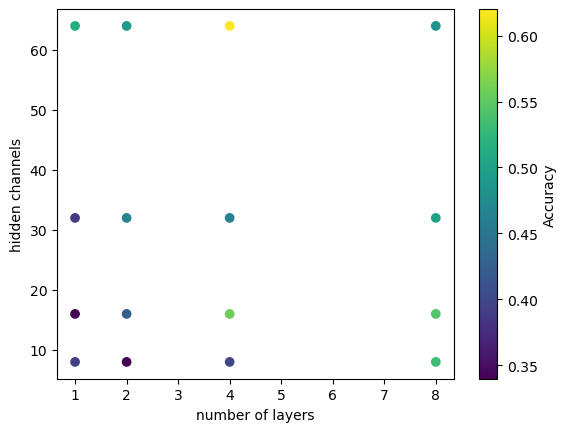

In [67]:
plt.scatter(x,y,c=accs)
plt.colorbar(label='Accuracy')
plt.xlabel('number of layers')
plt.ylabel('hidden channels')
plt.savefig('n_layers_vs_channels')
plt.show()

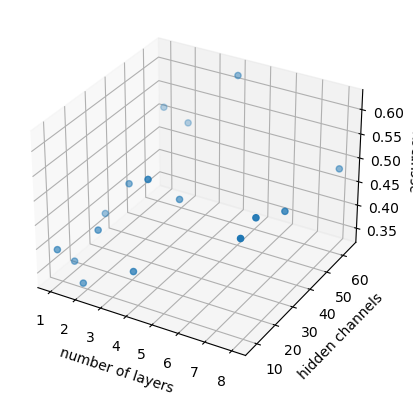

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,accs)
ax.set_xlabel('number of layers')
ax.set_ylabel('hidden channels')
ax.set_zlabel('accuracy')
plt.show()